<a href="https://colab.research.google.com/github/codeplinth/pytorchbootcamp/blob/master/PyTorch_31_Dropout_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [34]:
# The function for plotting the diagram

def plot_decision_regions_3class(data_set, model=None):
    cmap_light = ListedColormap([ '#0000FF','#FF0000'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    newdata = np.c_[xx.ravel(), yy.ravel()]
    
    Z = data_set.multi_dim_poly(newdata).flatten()
    f = np.zeros(Z.shape)
    f[Z > 0] = 1
    f = f.reshape(xx.shape)
    if model != None:
        model.eval()
        XX = torch.Tensor(newdata)
        _, yhat = torch.max(model(XX), 1)
        yhat = yhat.numpy().reshape(xx.shape)
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light) 

    plt.title("decision region vs True decision boundary")

In [35]:
#Define a function to calculate accuracy
def accuracy(model,dataset):
  _,y_pred = torch.max(model(dataset.x),1)
  return (y_pred == dataset.y).numpy().mean()

In [36]:
# Create data class for creating dataset object

class Data(Dataset):
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a
       
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)    
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len
    def plot(self):
        X = data_set.x.numpy()
        y = data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = data_set.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0') 
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    
    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

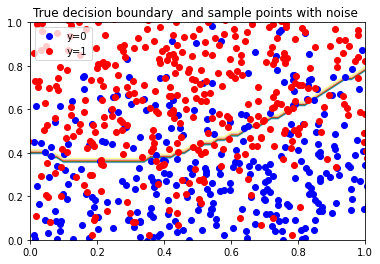

In [37]:
#create dataset object
data_set = Data(noise_std=0.2)
data_set.plot()

In [38]:
# Get some validation data
torch.manual_seed(0) 
validation_set = Data(train=False)

In [39]:
#Create the network
class NeuralNet(nn.Module):
  def __init__(self,D_in,H,D_out,p=0):
    super(NeuralNet,self).__init__()
    self.dropout = nn.Dropout(p=p)
    self.l1 = nn.Linear(D_in,H)
    self.l2 = nn.Linear(H,H)
    self.l3 = nn.Linear(H,D_out)
  def forward(self,x):
    out1 = F.relu(self.dropout(self.l1(x)))
    out2 = F.relu(self.dropout(self.l2(out1)))
    y_pred = self.l3(out2)
    return y_pred


In [40]:
model = NeuralNet(2,300,2)
model_dropout = NeuralNet(2,300,2,p=0.5)

In [41]:
model_dropout.train()

NeuralNet(
  (dropout): Dropout(p=0.5, inplace=False)
  (l1): Linear(in_features=2, out_features=300, bias=True)
  (l2): Linear(in_features=300, out_features=300, bias=True)
  (l3): Linear(in_features=300, out_features=2, bias=True)
)

In [42]:
optimizer = optim.Adam(model.parameters(),lr=0.01)
optimizer_dropout = optim.Adam(model_dropout.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [43]:
LOSS = {'training_loss_no_dropout':[],
        'validation_loss_no_dropout':[],
        'training_loss_dropout':[],
        'validation_loss_dropout':[]
}

In [44]:
EPOCHS = 1000
def train_model(EPOCHS):
  for epoch in range(EPOCHS):
    y_pred = model(data_set.x)
    y_pred_dropout = model_dropout(data_set.x)
    loss = criterion(y_pred,data_set.y)
    loss_dropout = criterion(y_pred_dropout,data_set.y)

    optimizer.zero_grad()
    optimizer_dropout.zero_grad()

    LOSS['training_loss_no_dropout'].append(loss.item())
    LOSS['validation_loss_no_dropout'].append(criterion(model(validation_set.x),validation_set.y).item())
    LOSS['training_loss_dropout'].append(loss_dropout.item())
    model_dropout.eval()
    LOSS['validation_loss_dropout'].append(criterion(model_dropout(validation_set.x),validation_set.y).item())
    model_dropout.train()

    loss.backward()
    loss_dropout.backward()

    optimizer.step()
    optimizer_dropout.step()


In [45]:
train_model(EPOCHS)

In [46]:
model_dropout.eval()

NeuralNet(
  (dropout): Dropout(p=0.5, inplace=False)
  (l1): Linear(in_features=2, out_features=300, bias=True)
  (l2): Linear(in_features=300, out_features=300, bias=True)
  (l3): Linear(in_features=300, out_features=2, bias=True)
)

In [47]:
print(accuracy(model,validation_set))

0.761


In [48]:
print(accuracy(model_dropout,validation_set))

0.824


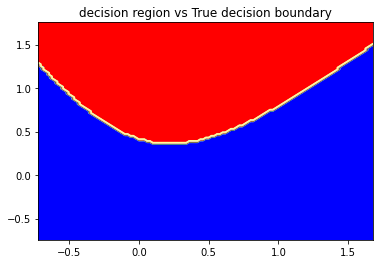

In [49]:
plot_decision_regions_3class(data_set)

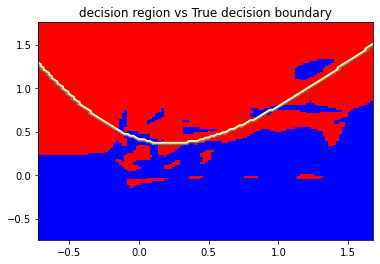

In [50]:
plot_decision_regions_3class(data_set, model)

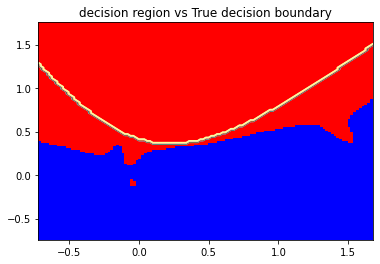

In [51]:
plot_decision_regions_3class(data_set, model_dropout)

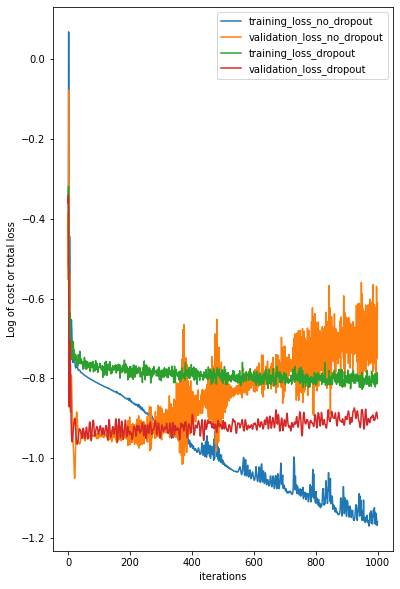

In [52]:
plt.figure(figsize=(6.1, 10))
def plot_LOSS():
    for key, value in LOSS.items():
        plt.plot(np.log(np.array(value)), label=key)
        plt.legend()
        plt.xlabel("iterations")
        plt.ylabel("Log of cost or total loss")

plot_LOSS()